In [1]:
import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
      


In [2]:
def ReadImage(ImageFolderPath):
    Images = []									
    ImageNames = os.listdir(ImageFolderPath)

    for i in ImageNames:
        InputImage = cv2.imread(ImageFolderPath + "/" + i) 
        Images.append(InputImage)                               
    return Images

In [3]:
def FindMatches(BaseImage, SecImage):
    # Using SIFT to find the keypoints and decriptors in the images
    Sift = cv2.SIFT_create()
    BaseImage_kp, BaseImage_des = Sift.detectAndCompute(cv2.cvtColor(BaseImage, cv2.COLOR_BGR2GRAY), None)
    SecImage_kp, SecImage_des = Sift.detectAndCompute(cv2.cvtColor(SecImage, cv2.COLOR_BGR2GRAY), None)

    # Using Brute Force matcher to find matches.
    BF_Matcher = cv2.BFMatcher()
    InitialMatches = BF_Matcher.knnMatch(BaseImage_des, SecImage_des, k=2)

    # Applytng ratio test and filtering out the good matches.
    GoodMatches = []
    for m, n in InitialMatches:
        if m.distance < 0.75 * n.distance:
            GoodMatches.append([m])

    return GoodMatches, BaseImage_kp, SecImage_kp





    


In [4]:
def FindHomography(Matches, BaseImage_kp, SecImage_kp):
    # If less than 4 matches found, exit the code.
    if len(Matches) < 4:
        print("\nNot enough matches found between the images.\n")
        exit(0)

    # Storing coordinates of points corresponding to the matches found in both the images
    BaseImage_pts = []
    SecImage_pts = []
    for Match in Matches:
        BaseImage_pts.append(BaseImage_kp[Match[0].queryIdx].pt)
        SecImage_pts.append(SecImage_kp[Match[0].trainIdx].pt)

    # Changing the datatype to "float32" for finding homography
    BaseImage_pts = np.float32(BaseImage_pts)
    SecImage_pts = np.float32(SecImage_pts)

    # Finding the homography matrix(transformation matrix).
    (HomographyMatrix, Status) = cv2.findHomography(SecImage_pts, BaseImage_pts, cv2.RANSAC, 4.0)

    return HomographyMatrix, Status

In [5]:
def GetNewFrameSizeAndMatrix(HomographyMatrix, Sec_ImageShape, Base_ImageShape):
    # Reading the size of the image
    (Height, Width) = Sec_ImageShape
    
    # Taking the matrix of initial coordinates of the corners of the secondary image
    # Stored in the following format: [[x1, x2, x3, x4], [y1, y2, y3, y4], [1, 1, 1, 1]]
    # Where (xt, yt) is the coordinate of the i th corner of the image. 
    InitialMatrix = np.array([[0, Width - 1, Width - 1, 0],
                              [0, 0, Height - 1, Height - 1],
                              [1, 1, 1, 1]])
    
    # Finding the final coordinates of the corners of the image after transformation.
    # NOTE: Here, the coordinates of the corners of the frame may go out of the 
    # frame(negative values). We will correct this afterwards by updating the 
    # homography matrix accordingly.
    FinalMatrix = np.dot(HomographyMatrix, InitialMatrix)

    [x, y, c] = FinalMatrix
    x = np.divide(x, c)
    y = np.divide(y, c)

    # Finding the dimentions of the stitched image frame and the "Correction" factor
    min_x, max_x = int(round(min(x))), int(round(max(x)))
    min_y, max_y = int(round(min(y))), int(round(max(y)))

    New_Width = max_x
    New_Height = max_y
    Correction = [0, 0]
    if min_x < 0:
        New_Width -= min_x
        Correction[0] = abs(min_x)
    if min_y < 0:
        New_Height -= min_y
        Correction[1] = abs(min_y)
    
    # Again correcting New_Width and New_Height
    # Helpful when secondary image is overlaped on the left hand side of the Base image.
    if New_Width < Base_ImageShape[1] + Correction[0]:
        New_Width = Base_ImageShape[1] + Correction[0]
    if New_Height < Base_ImageShape[0] + Correction[1]:
        New_Height = Base_ImageShape[0] + Correction[1]

    # Finding the coordinates of the corners of the image if they all were within the frame.
    x = np.add(x, Correction[0])
    y = np.add(y, Correction[1])
    OldInitialPoints = np.float32([[0, 0],
                                   [Width - 1, 0],
                                   [Width - 1, Height - 1],
                                   [0, Height - 1]])
    NewFinalPonts = np.float32(np.array([x, y]).transpose())

    # Updating the homography matrix. Done so that now the secondary image completely 
    # lies inside the frame
    HomographyMatrix = cv2.getPerspectiveTransform(OldInitialPoints, NewFinalPonts)
    
    return [New_Height, New_Width], Correction, HomographyMatrix

In [6]:
def Convert_xy(x, y):
    global center, f

    xt = ( f * np.tan( (x - center[0]) / f ) ) + center[0]
    yt = ( (y - center[1]) / np.cos( (x - center[0]) / f ) ) + center[1]
    
    return xt, yt

In [7]:
def ProjectOntoCylinder(InitialImage):
    global w, h, center, f
    h, w = InitialImage.shape[:2]
    center = [w // 2, h // 2]
    f = 1100       # 1100 field; 1000 Sun; 1500 Rainier; 1050 Helens
    
    # Creating a blank transformed image
    TransformedImage = np.zeros(InitialImage.shape, dtype=np.uint8)
    
    # Storing all coordinates of the transformed image in 2 arrays (x and y coordinates)
    AllCoordinates_of_ti =  np.array([np.array([i, j]) for i in range(w) for j in range(h)])
    ti_x = AllCoordinates_of_ti[:, 0]
    ti_y = AllCoordinates_of_ti[:, 1]
    
    # Finding corresponding coordinates of the transformed image in the initial image
    ii_x, ii_y = Convert_xy(ti_x, ti_y)

    # Rounding off the coordinate values to get exact pixel values (top-left corner)
    ii_tl_x = ii_x.astype(int)
    ii_tl_y = ii_y.astype(int)

    # Finding transformed image points whose corresponding 
    # initial image points lies inside the initial image
    GoodIndices = (ii_tl_x >= 0) * (ii_tl_x <= (w-2)) * \
                  (ii_tl_y >= 0) * (ii_tl_y <= (h-2))

    # Removing all the outside points from everywhere
    ti_x = ti_x[GoodIndices]
    ti_y = ti_y[GoodIndices]
    
    ii_x = ii_x[GoodIndices]
    ii_y = ii_y[GoodIndices]

    ii_tl_x = ii_tl_x[GoodIndices]
    ii_tl_y = ii_tl_y[GoodIndices]

    # Bilinear interpolation
    dx = ii_x - ii_tl_x
    dy = ii_y - ii_tl_y

    weight_tl = (1.0 - dx) * (1.0 - dy)
    weight_tr = (dx)       * (1.0 - dy)
    weight_bl = (1.0 - dx) * (dy)
    weight_br = (dx)       * (dy)
    
    TransformedImage[ti_y, ti_x, :] = ( weight_tl[:, None] * InitialImage[ii_tl_y,     ii_tl_x,     :] ) + \
                                      ( weight_tr[:, None] * InitialImage[ii_tl_y,     ii_tl_x + 1, :] ) + \
                                      ( weight_bl[:, None] * InitialImage[ii_tl_y + 1, ii_tl_x,     :] ) + \
                                      ( weight_br[:, None] * InitialImage[ii_tl_y + 1, ii_tl_x + 1, :] )


    # Getting x coorinate to remove black region from right and left in the transformed image
    min_x = min(ti_x)

    # Cropping out the black region from both sides (using symmetricity)
    TransformedImage = TransformedImage[:, min_x : -min_x, :]

    return TransformedImage, ti_x-min_x, ti_y

In [8]:
def StitchImages(BaseImage, SecImage):
    # Applying Cylindrical projection on SecImage
    SecImage_Cyl, mask_x, mask_y = ProjectOntoCylinder(SecImage)

    # Getting SecImage Mask
    SecImage_Mask = np.zeros(SecImage_Cyl.shape, dtype=np.uint8)
    SecImage_Mask[mask_y, mask_x, :] = 255

    # Finding matches between the 2 images and their keypoints
    Matches, BaseImage_kp, SecImage_kp = FindMatches(BaseImage, SecImage_Cyl)
    
    # Finding homography matrix.
    HomographyMatrix, Status = FindHomography(Matches, BaseImage_kp, SecImage_kp)
    
    # Finding size of new frame of stitched images and updating the homography matrix 
    NewFrameSize, Correction, HomographyMatrix = GetNewFrameSizeAndMatrix(HomographyMatrix, SecImage_Cyl.shape[:2], BaseImage.shape[:2])

    # Finally placing the images upon one another.
    SecImage_Transformed = cv2.warpPerspective(SecImage_Cyl, HomographyMatrix, (NewFrameSize[1], NewFrameSize[0]))
    SecImage_Transformed_Mask = cv2.warpPerspective(SecImage_Mask, HomographyMatrix, (NewFrameSize[1], NewFrameSize[0]))
    BaseImage_Transformed = np.zeros((NewFrameSize[0], NewFrameSize[1], 3), dtype=np.uint8)
    BaseImage_Transformed[Correction[1]:Correction[1]+BaseImage.shape[0], Correction[0]:Correction[0]+BaseImage.shape[1]] = BaseImage

    StitchedImage = cv2.bitwise_or(SecImage_Transformed, cv2.bitwise_and(BaseImage_Transformed, cv2.bitwise_not(SecImage_Transformed_Mask)))

    return StitchedImage

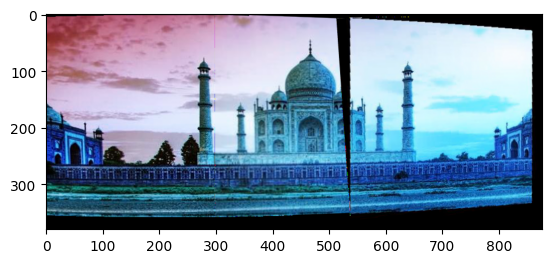

In [9]:

if __name__ == "__main__":
    # Reading images.
    Images = ReadImage("/media/ajit-pc/New Volume/19. Computer vision/Assignment2/Dataset/problem2B-3")
    
    BaseImage, _, _ = ProjectOntoCylinder(Images[0])
    for i in range(1, len(Images)):
        StitchedImage = StitchImages(BaseImage, Images[i])

        BaseImage = StitchedImage.copy()    
    plt.imshow(BaseImage)
    plt.show()
